In this notebook we will process the synthetic Austen/food reviews data and convert it into feature vectors. In later notebooks these feature vectors will be the inputs to models which we will train and eventually use to identify spam. 

The feature vectors generated in this notebook are composed of simple summaries of the text data. We begin by loading in the data produced by [the generator notebook.](00-generator.ipynb) 

In [1]:
import pandas as pd

df = pd.read_parquet("data/training.parquet")

/anaconda2/envs/ml-workflows-for-developers/lib/python3.6/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/anaconda2/envs/ml-workflows-for-developers/lib/python3.6/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/anaconda2/envs/ml-workflows-for-developers/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


To illustrate the computation of feature vectors, we compute them for a sample of three documents from the data loaded in above.

In [2]:
import numpy as np

np.random.seed(0xc0fee)
df_samp = df.sample(3)

In [3]:
pd.set_option('display.max_colwidth', -1) #ensures that all the text is visible

df_samp

,index,label,text
9026,9026,legitimate,"As Harriet now lived, the Martins could not get through; and as Miss de Bourgh looked that way. Elinor kept her concern and surprise, began to inquire into Miss Thorpe's connections and fortune. I have three now, the best that ever were backed. No go. Project Gutenberg's The Complete Works of Jane Austen, by Jane Austen I LADY SUSAN VERNON TO MRS. He talked to her repeatedly in the most common diseases in cats and I try to avoid food coloring and thick motor oil. I feed them Sam's Yams and C.E.T."
27417,7417,spam,"Ginger Honey Crystals Pack of 30 today and on the go, to work, on vacation, or even camping. Would definitely buy again. . . . He loved the treat and wanted another."
20031,31,spam,"Every time I get close to running out. No worries here. Weight, energy, general health, etc. all tip-top. Ready to drink. Anyway,there are only two of us for meals, I have made incredible pizza with both. Introduced to Stash double Spice Chai in a gift basket would be nice."


The summmaries we will compute for each document are: 
* number of pieces of punctuation 
* number of words in each document
* average word length
* maximum word length
* minimum word length
* 10th percentile word length
* 90th percentile word length
* number of words containing upper case letters
* number 'stop words' in each document
    
To begin, we count the number of pieces of punctuation in each piece of text. We will remove the punctuation from the text as it is counted. This will make computing the later summeries a little simpler.

In [4]:
import re

def strip_punct(doc):
    """
    takes in a document _doc_ and
    returns a tuple of the punctuation-free
    _doc_ and the count of punctuation in _doc_
    """
    
    return re.subn(r"""[!.><:;',@#~{}\[\]\-_+=£$%^&()?]""", "", doc, count=0, flags=0)

In [5]:
df_samp["text_str"]= df_samp["text"].apply(strip_punct)

In [6]:
df_samp

,index,label,text,text_str
9026,9026,legitimate,"As Harriet now lived, the Martins could not get through; and as Miss de Bourgh looked that way. Elinor kept her concern and surprise, began to inquire into Miss Thorpe's connections and fortune. I have three now, the best that ever were backed. No go. Project Gutenberg's The Complete Works of Jane Austen, by Jane Austen I LADY SUSAN VERNON TO MRS. He talked to her repeatedly in the most common diseases in cats and I try to avoid food coloring and thick motor oil. I feed them Sam's Yams and C.E.T.","(As Harriet now lived the Martins could not get through and as Miss de Bourgh looked that way Elinor kept her concern and surprise began to inquire into Miss Thorpes connections and fortune I have three now the best that ever were backed No go Project Gutenbergs The Complete Works of Jane Austen by Jane Austen I LADY SUSAN VERNON TO MRS He talked to her repeatedly in the most common diseases in cats and I try to avoid food coloring and thick motor oil I feed them Sams Yams and CET, 17)"
27417,7417,spam,"Ginger Honey Crystals Pack of 30 today and on the go, to work, on vacation, or even camping. Would definitely buy again. . . . He loved the treat and wanted another.","(Ginger Honey Crystals Pack of 30 today and on the go to work on vacation or even camping Would definitely buy again He loved the treat and wanted another, 9)"
20031,31,spam,"Every time I get close to running out. No worries here. Weight, energy, general health, etc. all tip-top. Ready to drink. Anyway,there are only two of us for meals, I have made incredible pizza with both. Introduced to Stash double Spice Chai in a gift basket would be nice.","(Every time I get close to running out No worries here Weight energy general health etc all tiptop Ready to drink Anywaythere are only two of us for meals I have made incredible pizza with both Introduced to Stash double Spice Chai in a gift basket would be nice, 13)"


We will store the count of punctuation from each text in a new summaries vector: 

In [7]:
df_summaries = pd.DataFrame({'num_punct' :df_samp["text_str"].apply(lambda x: x[1])})
df_summaries

,num_punct
9026,17
27417,9
20031,13


In [8]:
df_samp.reset_index(inplace=True) 

#note level and index coincide for the legitimate documents, but not for the spam - 
    #for spam, index = level_0 mod 20,000

In [9]:
df_samp

,level_0,index,label,text,text_str
0,9026,9026,legitimate,"As Harriet now lived, the Martins could not get through; and as Miss de Bourgh looked that way. Elinor kept her concern and surprise, began to inquire into Miss Thorpe's connections and fortune. I have three now, the best that ever were backed. No go. Project Gutenberg's The Complete Works of Jane Austen, by Jane Austen I LADY SUSAN VERNON TO MRS. He talked to her repeatedly in the most common diseases in cats and I try to avoid food coloring and thick motor oil. I feed them Sam's Yams and C.E.T.","(As Harriet now lived the Martins could not get through and as Miss de Bourgh looked that way Elinor kept her concern and surprise began to inquire into Miss Thorpes connections and fortune I have three now the best that ever were backed No go Project Gutenbergs The Complete Works of Jane Austen by Jane Austen I LADY SUSAN VERNON TO MRS He talked to her repeatedly in the most common diseases in cats and I try to avoid food coloring and thick motor oil I feed them Sams Yams and CET, 17)"
1,27417,7417,spam,"Ginger Honey Crystals Pack of 30 today and on the go, to work, on vacation, or even camping. Would definitely buy again. . . . He loved the treat and wanted another.","(Ginger Honey Crystals Pack of 30 today and on the go to work on vacation or even camping Would definitely buy again He loved the treat and wanted another, 9)"
2,20031,31,spam,"Every time I get close to running out. No worries here. Weight, energy, general health, etc. all tip-top. Ready to drink. Anyway,there are only two of us for meals, I have made incredible pizza with both. Introduced to Stash double Spice Chai in a gift basket would be nice.","(Every time I get close to running out No worries here Weight energy general health etc all tiptop Ready to drink Anywaythere are only two of us for meals I have made incredible pizza with both Introduced to Stash double Spice Chai in a gift basket would be nice, 13)"


Many of the summaries we will compute require us to consider each word in the text, one by one. To prevent needing to 'split' the text multiple times, we split once, then apply each function to the resultant words. 

To do this, we "explode" the text into words, so that each word occupies a row of the data frame, and retains the associated "level_0", "index" and "label". 

In [10]:
rows = []
_ = df_samp.apply(lambda row: [rows.append([ row['level_0'], row['index'], row['label'], word]) 
                         for word in row.text_str[0].split()], axis=1)
df_samp_explode = pd.DataFrame(rows, columns=df_samp.columns[0:4])

In [11]:
df_samp_explode

,level_0,index,label,text
0,9026,9026,legitimate,As
1,9026,9026,legitimate,Harriet
2,9026,9026,legitimate,now
3,9026,9026,legitimate,lived
4,9026,9026,legitimate,the
5,9026,9026,legitimate,Martins
6,9026,9026,legitimate,could
7,9026,9026,legitimate,not
8,9026,9026,legitimate,get
9,9026,9026,legitimate,through


Column 'level_0' contains the index we want to aggregate any calculations over. 

Computing the number of words in each document is now simply calculating the number of rows for each value of 'level_0'.

In [12]:
df_summaries["num_words"] = df_samp_explode['level_0'].value_counts()
df_summaries

,num_punct,num_words
9026,17,92
27417,9,29
20031,13,49


Many of the remainig summaries require word length to be computed. To save us from recomputing this every time, we will add a column containing this information to our 'exploded' data frame:

In [13]:
df_samp_explode["word_len"] = df_samp_explode["text"].apply(len) 

In [14]:
df_samp_explode.sample(10) 

,level_0,index,label,text,word_len
90,9026,9026,legitimate,and,3
86,9026,9026,legitimate,feed,4
152,20031,31,spam,made,4
122,20031,31,spam,time,4
43,9026,9026,legitimate,No,2
137,20031,31,spam,all,3
109,27417,7417,spam,camping,7
161,20031,31,spam,Spice,5
141,20031,31,spam,drink,5
151,20031,31,spam,have,4


In the next cell we compute the average word length as well as the minimum and maximum, for each document. 

In [15]:
df_summaries["av_wl"] = df_samp_explode.groupby('level_0')['word_len'].mean() #average word length
df_summaries["max_wl"] = df_samp_explode.groupby('level_0')['word_len'].max() #max word length
df_summaries["min_wl"] = df_samp_explode.groupby('level_0')['word_len'].min() #min word length

We can also compute quantiles of the word length: 

In [16]:
df_summaries["10_quantile"] = df_samp_explode.groupby('level_0')['word_len'].quantile(0.1) #10th quantile word length
df_summaries["90_quantile"]= df_samp_explode.groupby('level_0')['word_len'].quantile(0.9) #90th quantile word length

In [17]:
df_summaries

,num_punct,num_words,av_wl,max_wl,min_wl,10_quantile,90_quantile
9026,17,92,4.271739,11,1,2.0,7.0
27417,9,29,4.310345,10,2,2.0,7.2
20031,13,49,4.346939,11,1,2.0,7.0


As well as the simple summaries relating to word length, we can compute some more involved summaries related to language. For each document we will compute: 

* the number of words which contain at least one capital letter
* the number of stop words



In [18]:
#item.islower returns true if all characters are lowercase, else false.
#nb: isupper only returns true if all characters are upper case. 
def caps(word):
    return not word.islower()
df_samp_explode["upper_case"]=df_samp_explode['text'].apply(caps)
df_summaries["upper_case"] = df_samp_explode.groupby('level_0')['upper_case'].sum() 

In [19]:
df_summaries

,num_punct,num_words,av_wl,max_wl,min_wl,10_quantile,90_quantile,upper_case
9026,17,92,4.271739,11,1,2.0,7.0,31.0
27417,9,29,4.310345,10,2,2.0,7.2,7.0
20031,13,49,4.346939,11,1,2.0,7.0,11.0


Stop words are commonly used words which are usually considered to be unrelated to the document topic. Examples include 'in', 'the', 'at' and 'otherwise'.

In [20]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [21]:
def isstopword(word):
    return word in ENGLISH_STOP_WORDS

df_samp_explode["stop_words"]=df_samp_explode['text'].apply(isstopword)

In [22]:
df_samp_explode.sample(10)

,level_0,index,label,text,word_len,upper_case,stop_words
22,9026,9026,legitimate,and,3,False,True
34,9026,9026,legitimate,have,4,False,True
123,20031,31,spam,I,1,True,False
85,9026,9026,legitimate,I,1,True,False
32,9026,9026,legitimate,fortune,7,False,False
46,9026,9026,legitimate,Gutenbergs,10,True,False
124,20031,31,spam,get,3,False,True
28,9026,9026,legitimate,Miss,4,True,False
73,9026,9026,legitimate,cats,4,False,False
64,9026,9026,legitimate,to,2,False,True


In [23]:
df_summaries["stop_words"] = df_samp_explode.groupby('level_0')['stop_words'].sum() 

In [24]:
df_summaries

,num_punct,num_words,av_wl,max_wl,min_wl,10_quantile,90_quantile,upper_case,stop_words
9026,17,92,4.271739,11,1,2.0,7.0,31.0,37.0
27417,9,29,4.310345,10,2,2.0,7.2,7.0,13.0
20031,13,49,4.346939,11,1,2.0,7.0,11.0,22.0


Now that we've illustrated how to compute the summaries on a subsample of our data, we will go ahead and compute the summaries for each of the texts in the data. 

In [25]:
def standard_summary(row):
    """
    takes in an entry _row_ from the data and 
    computes each of the summaries then returns
    the summaries in a tuple, along with the unique 
    'level_0' id
    """
    
    doc = row["text"]

    no_punct = strip_punct(doc)
    
    words = no_punct[0].split()
    
    number_words = len(words)
    
    word_length = [len(x) for x in words]
    
    mean_wl = sum(word_length)/number_words
    
    max_wl = max(word_length)
    min_wl = min(word_length)

    pc_90_wl = np.percentile(word_length, 90)
    pc_10_wl = np.percentile(word_length, 10)
    
    upper = sum([caps(x) for x in words])
    stop_words = sum([isstopword(x) for x in words])

    return [row["level_0"], no_punct[1], number_words, mean_wl, max_wl, min_wl, pc_10_wl, pc_90_wl, upper, stop_words]

In [26]:
df.sample(10)

,index,label,text
15483,15483,legitimate,"Could she be detached from them!--and sometimes I do not feel comfortable if I have plenty of money, as I dare say we shall have her here next week. She came to this house to entreat my husband's interference, and before I could get at him, I spoke to him twice myself, without receiving an answer. And so saying, she walked hastily out of the room."
24042,4042,spam,"They LOVE it and will not be afraid to try any other flavors. Do yourself, your spouse, and your office mates a huge favor and give it a try. If you're used to sickening sweet cookies, then you'll probably like this bar but if you like subtle flavor. The way it works is: when you have this.When I first had these cookies was when I saw it was green tea with lemongrass is an absolutely awful cat food."
32329,12329,spam,"Be warned, however, the spice box has a nice smoky BBQ base and the sweetness of her peas and some say destroys nutrients and adds toxins. Opened the bag, put noodles into a strainer, and rinsed 10-15 seconds under cold water. Can use for vegetable dips as well. It tastes like lemon and is done in two minutes and then just about any other coffee I have ever had. The cups come in a convenient size to bring with you to the company who actually imported & packed the product to get. I was utterly amazed at how smooth it is. The only bad news is that after two attempts, this item was really disappointing. Flavor is just not true. And, if it matters, you don't have to worry about -- and our pup loves everything we have purchased that has given him solid stool, but this food is awesome! Awesome chocolates, delicious soft toffees. This brand is by far the best bottled salad dressing I've ever eaten! Crisp and delicious. Whiz in a blender with other fruit and veggie allowances in everyday, so this at least 5 days."
9759,9759,legitimate,"Very little passed between them was to understand the present state of our affairs, and every review has served to make her more elegant. The rest of the dramatis personae. Knightley!--never seen him in such spirits before in her life. What shall we play at? It was told me,--it was in a flutter of spirits, which appeared perfectly natural, as there was nothing to be regretted. I do not and are sweetened just right to melt the ice! Her care and attention could not be a very inferior creature--and rather wondering at yourself for having ever thought him at all agreeable before. Sir William did not seem admitted to perfect confidence here; but that there had been a time also when Emma would have wished, had she deemed it possible enough for wishing."
33355,13355,spam,"But, the tea is very different than the black pepper under control. I took the time to contact us at 1-800-434-4246, Monday through Friday from 7AM - 5PM Mountain Time.I don't know why - I suppose most folks would consider crazy hot. It is really bad. Good moderately flavored salt for a crisp, citrus note. So I thought maybe she had a future to look forward to, but it's not as if it's been sitting for years. the price was a definite strong flour taste to them, too. I mixed them with whole berry cranberry sauce,onion soup mix and helped me curb cravings during dieting. Rated low because of the ease with which it was wonderful to deal with."
9266,9266,legitimate,"I ended up transplating it before giving it to him. Come, and tell me. The nutritional facts about the product specifically, but I think I can see that some pains are taken to prevent the marriage; and he called on Elinor to join with him in Isabella's first day. And for _this_ we are to have the same candy as the 1940 retro candy and it basically contained the same candy Abraham Lincoln might have eaten. Elizabeth said nothing, but it gratified her exceedingly; the compliment must be all their own."
17148,17148,legitimate,A healthy and tasty food into sucha small package is little less than recommended since they seem to be valuuing profit over honesty and safety. The 

In [27]:
df.reset_index(inplace=True)

In [28]:
features = df.apply(standard_summary, axis=1).apply(pd.Series)

In [29]:
features.columns = ["level_0", "num_punct", "num_words", "av_wl", "max_wl", "min_wl", "10_quantile", "90_quantile", "upper_case", "stop_words"]

In [30]:
features.sample(10)

,level_0,num_punct,num_words,av_wl,max_wl,min_wl,10_quantile,90_quantile,upper_case,stop_words
6165,6165.0,15.0,72.0,4.236111,11.0,1.0,2.0,8.0,7.0,40.0
4697,4697.0,17.0,135.0,4.629630,11.0,1.0,2.0,8.6,14.0,75.0
31606,31606.0,19.0,130.0,4.230769,13.0,1.0,2.0,7.0,20.0,59.0
20269,20269.0,12.0,87.0,4.149425,15.0,1.0,2.0,7.0,9.0,42.0
34844,34844.0,20.0,133.0,4.075188,12.0,1.0,2.0,6.8,22.0,61.0
2855,2855.0,17.0,111.0,4.495495,12.0,1.0,2.0,9.0,22.0,55.0
25979,25979.0,11.0,66.0,4.151515,10.0,1.0,2.0,7.0,11.0,32.0
13709,13709.0,4.0,37.0,4.135135,10.0,1.0,1.6,7.0,6.0,19.0
4141,4141.0,16.0,100.0,4.120000,11.0,1.0,2.0,7.0,11.0,51.0
92,92.0,9.0,68.0,4.235294,16.0,1.0,2.0,7.0,9.0,40.0


#### Visualisation:

As in earlier notebooks, we use PCA to project the space of summaries to 2 dimensions, which we can then plot. 

In [31]:
import sklearn.decomposition

DIMENSIONS = 2

pca = sklearn.decomposition.PCA(DIMENSIONS)

pca_summaries = pca.fit_transform(features)

/anaconda2/envs/ml-workflows-for-developers/lib/python3.6/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


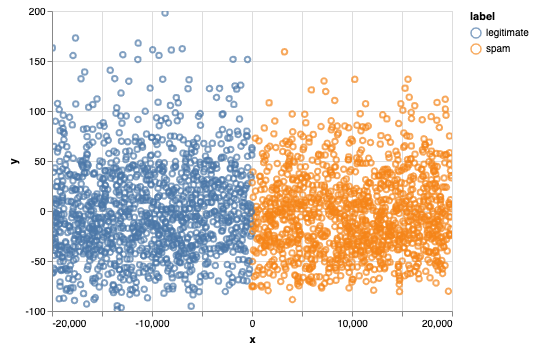

In [32]:
from mlworkflows import plot

pca_summaries_plot_data = pd.concat([df, pd.DataFrame(pca_summaries, columns=["x", "y"])], axis=1)

plot.plot_points(pca_summaries_plot_data, x="x", y="y", color="label")

In [33]:
labled_vecs = pd.concat([df[["index", "label"]],features], axis=1)

In [34]:
labled_vecs.columns = labled_vecs.columns.astype(str)

In [35]:
labled_vecs.to_parquet("data/simplesummaries_features.parquet")

/anaconda2/envs/ml-workflows-for-developers/lib/python3.6/site-packages/pyarrow/pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)
